# Особенности посторения процесса обучения нейронной сети

Больше о настройке обучения нейронных сетей можно найти, например, в:
* [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/) от Анедрея Карпатых.
* [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187) - статья 2018 год об обучении сверточных нейронных сетей
* [Tips for Model Training](https://docs.ultralytics.com/guides/model-training-tips/#community-resources) от известной команды `ultralytics` и другие гайд от них и других команд. 
* и в других тематических публикациях известных специалистов, например [тут](https://sebastianraschka.com/blog/2023/pytorch-faster.html), [тут](https://github.com/vahidk/EffectivePyTorch), [тут](https://github.com/rasbt/deeplearning-models)  а также официальные публикации `PyTorch`, [например](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html), и известные коллекции примеров, [например](https://madewithml.com/) или [тут](https://github.com/Conchylicultor/Deep-Learning-Tricks). 
<!-- и [тут](https://stackoverflow.com/questions/70554413/how-to-improve-the-performance-of-cnn-model-for-a-specific-dataset-getting-low). -->
* Важно также иметь в виду вопросы ускорения и вычислительной оптимизации обучения нейронных сетей, см., [например](https://habr.com/ru/companies/wunderfund/articles/820721/).
* А также важно иметь в виду вопросы настройки гиперпараметров обучения нейронных сетей, см., [например](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) и [тут](https://docs.ray.io/en/latest/tune/getting-started.html) и [тут](https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html).
* Курс включающий много примеров [тут](https://deeplearning.neuromatch.io/tutorials/W1D5_Optimization/chapter_title.html).
* Гайд [Deep Learning Tuning Playbook](https://github.com/google-research/tuning_playbook)
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

## Импорт `torch`

In [646]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [647]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [649]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader, random_split


import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange
import warnings
import pandas as pd

In [650]:
from torch_lr_finder import LRFinder

Настроим работу с `PyTorch` при помощи функции `setup_experiment`. Выбирем формат работы и устройство для работы.

Основные задачи функции `setup_experiment`:
Инициализация генераторов случайных чисел

* Устанавливает сиды для `Python, NumPy и PyTorch`

* Гарантирует одинаковые результаты при повторных запусках

* Настройка производительности `GPU`

```
    deterministic=True - полная воспроизводимость (медленнее)
    
    benchmark=True - максимальная скорость (не воспроизводимо)
    
    allow_tf32=True - ускорение вычислений с небольшой потерей точности
```

* Автоматический выбор устройства

Приоритет: `MPS (Apple Silicon)` → `CUDA` → `CPU`


* Функция возвращает `torch.device` для переноса моделей и данных на правильное устройство.

In [653]:
def setup_experiment(
    seed: int = 42,
    deterministic: bool = True,
    benchmark: bool = False,
    allow_tf32: bool = True,
    device_preference: str = "auto"
):
    """
    Настраивает окружение для воспроизводимых экспериментов в PyTorch.

    Args:
        seed (int): Сид для генераторов случайных чисел (Python, NumPy, PyTorch).
        deterministic (bool): Включить детерминированное поведение операций CuDNN (может снизить скорость).
        benchmark (bool): Включить CuDNN benchmark для автоматического выбора быстрых алгоритмов (не совместимо с deterministic=True).
        allow_tf32 (bool): Разрешить использование TensorFloat32 на Ampere+ GPU (ускоряет вычисления с небольшой потерей точности).
        device_preference (str): "cpu", "cuda", "mps", или "auto" — выбор устройства.

    Returns:
        torch.device: Устройство, на котором будут выполняться вычисления.
    """
    # --- 1. Установка сидов ---
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # для multi-GPU

    # --- 2. Настройки CuDNN ---
    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.deterministic = deterministic
        torch.backends.cudnn.benchmark = benchmark
        # benchmark=True ускоряет обучение, но нарушает воспроизводимость
        # deterministic=True гарантирует воспроизводимость, но может замедлить

    # --- 3. TF32 (только для CUDA на Ampere и новее) ---
    if torch.cuda.is_available() and hasattr(torch.backends.cuda, 'matmul'):
        torch.backends.cuda.matmul.allow_tf32 = allow_tf32
        torch.backends.cudnn.allow_tf32 = allow_tf32

    # --- 4. Подавление некоторых предупреждений (опционально) ---
    warnings.filterwarnings("ignore", category=UserWarning, module="torch")
    # Можно раскомментировать, если мешают предупреждения о нестабильных операциях

    # --- 5. Выбор устройства ---
    if device_preference == "auto":
        if torch.backends.mps.is_available():
            device = torch.device("mps")
        elif torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
    elif device_preference == "cpu":
        device = torch.device("cpu")
    elif device_preference == "cuda":
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            raise RuntimeError("CUDA not available, but 'cuda' was requested.")
    elif device_preference == "mps":
        if torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            raise RuntimeError("MPS not available, but 'mps' was requested.")
    else:
        raise ValueError("device_preference must be 'auto', 'cpu', 'cuda', or 'mps'")

    # --- 6. Печать итоговой конфигурации ---
    print(f"[Setup] Seed: {seed}")
    print(f"[Setup] Device: {device}")
    print(f"[Setup] CuDNN deterministic: {deterministic}, benchmark: {benchmark}")
    if torch.cuda.is_available():
        print(f"[Setup] TF32 enabled: {allow_tf32}")
    print("-" * 50)

    return device

In [654]:
device = setup_experiment()

[Setup] Seed: 42
[Setup] Device: cuda
[Setup] CuDNN deterministic: True, benchmark: False
[Setup] TF32 enabled: True
--------------------------------------------------


# Обзор библиотеки `timm`

Библиотека [timm (PyTorch Image Models)](https://huggingface.co/timm) один из самых востребованных инструментов для задач компьютерного зрения по  классификации изображений, а также для построения мощных `feature extractor` для более сложных архитектур. [Библиотека `timm`](https://github.com/huggingface/pytorch-image-models) поддерживает более 1000 предобученных моделей и имеет тесную интеграцию с экосистемой `Hugging Face`.

[Библиотека `timm`](https://huggingface.co/docs/timm/index) предоставляет встроенная поддержка `transfer learnin`: — например, замену головной части классификатора под нужное число классов или указание количество входных каналов (обычно 3 для `RGB`-изображений или 1 для `grayscale`). Это особенно удобно при работе с нестандартными доменами — от медицинских снимков до спутниковых изображений.

Помимо моделей, [библиотека `timm`](https://github.com/huggingface/pytorch-image-models) предоставляет готовые и согласованные пайплайны обработки данных, включая автоматическую настройку аугментаций и нормализации под конкретную архитектуру через `timm.data.create_transform()` и `resolve_data_config()`. Это гарантирует, что входные данные будут обработаны так же, как и при оригинальном предобучении — критически важное условие для стабильной и точной инференции.

[Библиотека `timm`](https://huggingface.co/docs/timm/index) полностью совместим с `Hugging Face Hub`: модели можно не только загружать напрямую из репозиториев `Hugging Face`, но и публиковать собственные веса, делая их доступными для сообщества. Такая интеграция упрощает воспроизводимость экспериментов и совместную работу.




In [657]:
import timm

Модели в `Timm` можно найти при помощи [поисковика hugging face](https://huggingface.co/models?pipeline_tag=image-classification&library=timm,pytorch&sort=trending) или функции  `list_models` как это показано ниже.

In [659]:
model_names = timm.list_models('mobilenetv3*')
print(model_names[:15])

['mobilenetv3_large_075', 'mobilenetv3_large_100', 'mobilenetv3_large_150d', 'mobilenetv3_rw', 'mobilenetv3_small_050', 'mobilenetv3_small_075', 'mobilenetv3_small_100']


В данном уроке посмотрим на работу с `TIMM` на  примере архитектуры типа `mobilenetv3_small`. Эта архитектура представляет собой модификацию архитектуры `mobilenet v3`.

В коде ниже

* `timm.create_model` — функция из библиотеки `timm` для загрузки архитектур нейронных сетей.

* `mobilenetv3_small_050` — название архитектуры конкрейтной: `mobilenet v3`.

* `pretrained=True` — загрузка весов, предварительно обученных на `ImageNet`.

* `num_classes=2` — количество классов на выходном слое (модель перестраивается под задачу бинарной классификации).

* `in_chans=3` — число входных каналов (3 соответствует `RGB`‑изображениям).



In [661]:
model = timm.create_model('mobilenetv3_small_050', pretrained=True, num_classes=2, in_chans=3)

In [662]:
model.eval() 
with torch.inference_mode():
    out = model(torch.randn(7, 3, 224, 224))
    
print(f'Logits shape: {out.shape}')  

Logits shape: torch.Size([7, 2])


Для такой модели, например, можно отдельно вызвать `feature_extractor` (`backbone`).

Параметры:
* `num_classes=0` — убирает классификатор,
* `global_pool=''` — отключает глобальный пуллинг.

In [664]:
backbone = timm.create_model('mobilenetv3_small_050', pretrained=True, num_classes=0, global_pool='')  # no head
features = backbone(torch.randn(7, 3, 224, 224))  
print(f"Feature map shape: {features.shape}")

Feature map shape: torch.Size([7, 1024, 7, 7])


Аналогично для модели с указанной головной частью можно получить головную часть при помощи метода `get_classifier` и заменить ее при помощи метода `reset_classifier`

In [666]:
model = timm.create_model('mobilenetv3_small_050', pretrained=True)

<blockquote>

Отметим, что при наличии локальной предобученной модели ее можно загрузить как чекпоинт

```python
    model = timm.create_model(
    'resnet18',
    pretrained=False,
    checkpoint_path='/path/to/resnet18.pth'  # путь к локальному .pth
)
```

</blockquote>

In [668]:
model.get_classifier()

Linear(in_features=1024, out_features=1000, bias=True)

In [669]:
model.reset_classifier(num_classes=2)

# Проверяем
print(model.get_classifier())  # → Linear(in_features=512, out_features=2, bias=True)

Linear(in_features=1024, out_features=2, bias=True)


Чтобы заморозить backbone, можно при помощи указанных методов сделать следующее

In [671]:
for param in model.parameters():
    param.requires_grad = False
# for param in model.get_classifier().parameters():
#     param.requires_grad = True
model.get_classifier().requires_grad_(True)

Linear(in_features=1024, out_features=2, bias=True)

Аналогично можно попытаться заменить головную часть на кастомную

In [673]:
import torch.nn as nn

custom_head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 2)  # 2 класса
)

In [674]:
model.classifier = custom_head  

На самом деле для кажой модели можно получить и заданную разработчиком конфигурацию как основку для будущих экспериментов

In [676]:
# 2. Получаем конфигурацию
cfg = model.default_cfg

print("Input size:", cfg['input_size'])      # (3, 224, 224)
print("Mean:", cfg['mean'])                  # [0.485, 0.456, 0.406]
print("Std:", cfg['std'])                    # [0.229, 0.224, 0.225]
print("Crop pct:", cfg['crop_pct'])          # 0.875
print("Interpolation:", cfg['interpolation'])# bicubic

Input size: (3, 224, 224)
Mean: (0.485, 0.456, 0.406)
Std: (0.229, 0.224, 0.225)
Crop pct: 0.875
Interpolation: bicubic


Отдельно преобразования могут быть получены для каждой модели следующим образом

In [678]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

config = resolve_data_config({}, model=model)
transform = create_transform(**config)
transform

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Аналогично, и насамом делее более правильно было бы менять конфигурацию для модели используя `resolve_data_config`

In [680]:
config = resolve_data_config({'input_size': (3, 384, 384)}, model=model)
transform = create_transform(**config)
transform

Compose(
    Resize(size=438, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(384, 384))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Аналогично можно создать новые преобразования при помощи `create_transform`

Важные замечания
1. `create_transform` ожидает `PIL.Image` на входе, а не с `ndaray` или `torch.tensor`.
2. Поэтому если открываете датасет вручную, то всегда делайте:
`Image.open(path).convert("RGB")`
3. Не применяйте `ToTensor()` вручную!
`create_transform` уже включает `ToTensor()` и `Normalize()` — не добавляйте их дважды!
4. Для валидации — только детерминированные преобразования. Никаких случайных аугментаций (если вы не делаете `test time augmentation` конечно)!
`is_training=False` → только `Resize, CenterCrop, ToTensor, Normalize`.


In [682]:
from timm.data import create_transform

transform_train = create_transform(
    input_size=224,
    is_training=True,
    color_jitter=0.4,
    auto_augment='rand-m9-mstd0.5-inc1',  # ← мощная аугментация
    re_prob=0.25,                          # Random Erasing
    re_mode='pixel',
    interpolation='bicubic',
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225)
)

transform_val = create_transform(
    input_size=224,
    is_training=False,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225)
)

## Настройки модели timm

### Создание модели

In [700]:
model = timm.create_model('mobilenetv3_small_050', 
                          pretrained=True, 
                          num_classes=len(names_classes), 
                          in_chans=3)

for param in model.parameters():
    param.requires_grad = False
model.get_classifier().requires_grad_(True)

Linear(in_features=1024, out_features=8, bias=True)

In [701]:
summary(model, (1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3                                   [1, 8]                    --
├─Conv2d: 1-1                                 [1, 16, 112, 112]         (432)
├─BatchNormAct2d: 1-2                         [1, 16, 112, 112]         32
│    └─Identity: 2-1                          [1, 16, 112, 112]         --
│    └─Hardswish: 2-2                         [1, 16, 112, 112]         --
├─Sequential: 1-3                             [1, 288, 7, 7]            --
│    └─Sequential: 2-3                        [1, 8, 56, 56]            --
│    │    └─DepthwiseSeparableConv: 3-1       [1, 8, 56, 56]            (600)
│    └─Sequential: 2-4                        [1, 16, 28, 28]           --
│    │    └─InvertedResidual: 3-2             [1, 16, 28, 28]           (1,512)
│    │    └─InvertedResidual: 3-3             [1, 16, 28, 28]           (2,552)
│    └─Sequential: 2-5                        [1, 24, 14, 14]           --
│   

In [702]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print('trainable p:', trainable_params, 'all p:', total_params)

trainable p: 8200 all p: 576424


In [703]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

### Установки для оубчения

#### Скорость обучения

Попробуем найти оптимальную скорость обучения

In [711]:
from timm.optim import create_optimizer_v2

optimizer = create_optimizer_v2(
    model,
    opt='adamw',          # или 'sgd', 'lion'
    lr=1e-7, # начальный LR очень мал
    weight_decay=1e-4,
    momentum=0.9          # для SGD
)

  0%|          | 0/30 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.17E-02


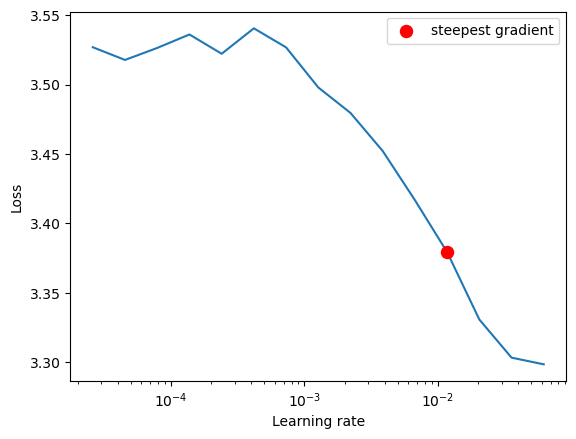

In [712]:
# Пример с PyTorch (без Lightning)
from torch_lr_finder import LRFinder

# optimizer = torch.optim.AdamW(trainable_parameters, lr=1e-7)  # начальный LR очень мал
criterion = torch.nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=1, num_iter=30) 
lr_finder.plot()  # строит график
lr_finder.reset()

#### Планировщик обучения

Другим полезным приемом будет использовать [планировщик скорости обучения](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) `learning rate scheduler`. Планировщик скорости обучения динамически изменяет скорость обучения во время обучения модели. 
 
В наиболее простом случае [планировщик скорости обучения](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate). Функция `learning rate scheduler` задается из пакета `torch.optim.lr_scheduler`. 

Одним из ключевых инструментов эффективного обучения нейросетей является планировщик скорости обучения [планировщик скорости обучения](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).). Он позволяет динамически изменять `learning rate` в процессе тренировки — например, начинать с высокого значения для быстрой сходимости, а затем постепенно уменьшать его для точной настройки весов.

В `PyTorch` планировщики  подключаются через модуль `torch.optim.lr_scheduler`.

Наиболее популярные следующие планировщики:

* `OneCycleLR` — `Learning rate` сначала плавно растёт до максимума, а затем плавно падает до очень маленького значения.
    * Эффект: Ускоряет обучение, Повышает точность, Автоматически находит хороший диапазон `LR` — не нужно долго подбирать вручную.
    * Когда использовать: При быстром прототипировании, Особенно хорошо работает с `SGD` и `AdamW`.
    
* `CosineAnnealingLR` — `Learning rate` сначала быстро, потом всё медленнее, приближаясь к минимальному значению. 
    * Эффект: меньше риска «перепрыгнуть» оптимум в конце. Может использоваться в циклическом режиме (с перезапуском), но чаще — как один цикл.
    * Когда использовать: При дообучении (`fine-tuning`). В задачах, где важна стабильность на последних эпохах.

* `ReduceLROnPlateau` — `Learning rate` реагирует на метрику (например, валидационную ошибку). Если метрика не улучшается несколько эпох подряд — LR уменьшается. 
    * Эффект: Адаптируется под данные — не зависит от заранее заданного числа эпох, Останавливает переобучение.
    * Когда использовать: В задачах с нестабильной сходимостью.
      
* ` Linear Warmup + Cosine Decay` —  Сначала `Learning rate` линейно растёт от малого значения до целевого («разогрев»), чтобы избежать нестабильности в начале. Затем следует косинусное затухание до конца обучения. 
    * Эффект: Стабилизирует начало обучения — особенно важно для трансформеров и больших моделе.
    * Когда использовать: В задачах с большими моделями.           

In [715]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

In [716]:
LR_START = 1.17E-02
# optimizer = optim.AdamW(trainable_parameters, lr=LR_START, amsgrad = False)
optimizer = create_optimizer_v2(
    model,
    opt='adamw',          # или 'sgd', 'lion'
    lr=LR_START, # начальный LR очень мал
    weight_decay=1e-4,
    momentum=0.9          # для SGD
)

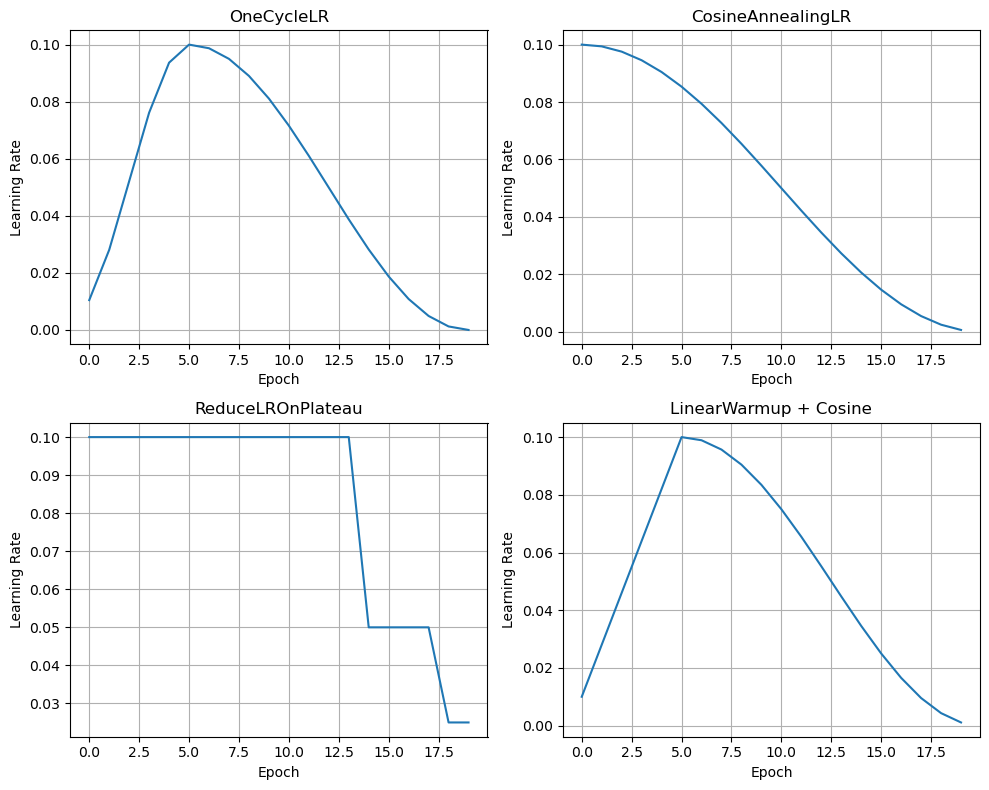

In [717]:
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt

# Фиктивная модель (нужна только для создания оптимизатора)
model = torch.nn.Linear(10, 1)
epochs = 20
steps_per_epoch = 100  # для OneCycleLR и SequentialLR

# Словарь для хранения LR по эпохам (для визуализации)
lrs = np.zeros((4, epochs))
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# 1. OneCycleLR
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler1 = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.1,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)

for epoch in range(epochs):
    for _ in range(steps_per_epoch):
        optimizer.step()
        scheduler1.step()  # шаг на КАЖДОМ батче
    lrs[0, epoch] = optimizer.param_groups[0]["lr"]

# 2. CosineAnnealingLR
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler2 = lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=epochs,
    eta_min=1e-6
)

for epoch in range(epochs):
    optimizer.step()
    lrs[1, epoch] = optimizer.param_groups[0]["lr"]
    scheduler2.step()  # шаг на КАЖДОЙ эпохе

# 3. ReduceLROnPlateau (эмулируем "валидационную метрику")
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler3 = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Эмуляция: loss сначала падает, потом стагнирует
val_losses = [0.5 / (i + 1) for i in range(10)] + [0.05] * 10  # 20 эпох

for epoch in range(epochs):
    optimizer.step()
    lrs[2, epoch] = optimizer.param_groups[0]["lr"]
    scheduler3.step(val_losses[epoch])  # передаём "метрику"

# 4. Linear Warmup + Cosine Decay (SequentialLR)
optimizer = optim.SGD(model.parameters(), lr=0.1)
warmup_epochs = 5

warmup_scheduler = lr_scheduler.LinearLR(
    optimizer,
    start_factor=0.1,
    total_iters=warmup_epochs
)

cosine_scheduler = lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=epochs - warmup_epochs,
    eta_min=1e-6
)

scheduler4 = lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[warmup_epochs]
)

for epoch in range(epochs):
    optimizer.step()
    lrs[3, epoch] = optimizer.param_groups[0]["lr"]
    scheduler4.step()

# Визуализация
schedulers_names = [
    'OneCycleLR',
    'CosineAnnealingLR',
    'ReduceLROnPlateau',
    'LinearWarmup + Cosine'
]

for j in range(4):
    ax = axs.ravel()[j]
    ax.plot(range(epochs), lrs[j])
    ax.set_title(schedulers_names[j])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.grid(True)

plt.tight_layout()
plt.show()

Ряд оптимайзеров и скедулеров может быть также вызван из timm

In [719]:
from timm.optim import create_optimizer_v2
from timm.scheduler import create_scheduler_v2
num_epochs = 30
# Оптимизатор
optimizer = create_optimizer_v2(
    model,
    opt='adamw',
    lr=LR_START,
    weight_decay=0.05
)

scheduler, _ = create_scheduler_v2(
    optimizer,
    sched='cosine',
    num_epochs=num_epochs,
    min_lr=1e-6,
    warmup_lr=1e-6,
    warmup_epochs=3
)

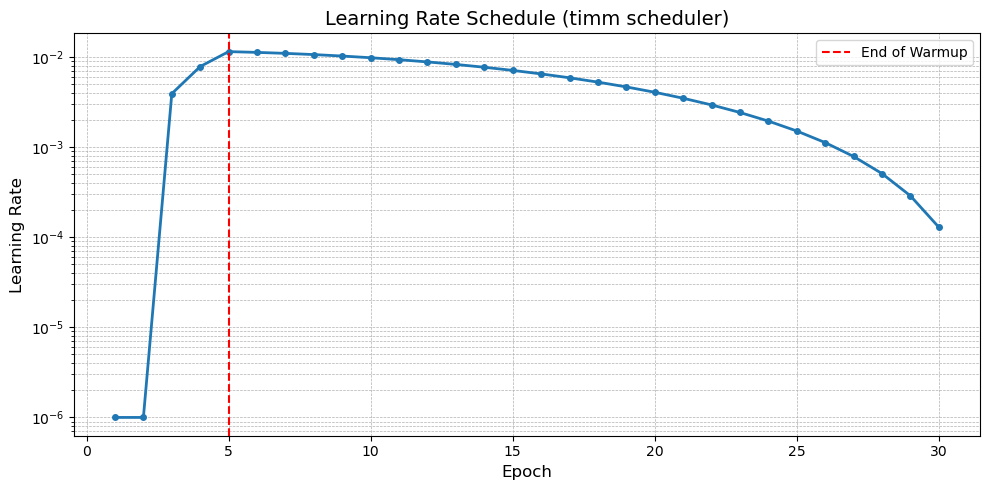

In [720]:
# Собираем значения LR по эпохам
lrs = []
for epoch in range(num_epochs):
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    scheduler.step(epoch)

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), lrs, marker='o', linewidth=2, markersize=4)
plt.title('Learning Rate Schedule (timm scheduler)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.yscale('log')  # логарифмическая шкала — иначе пик warmup'а "забьёт" график
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.axvline(x=5, color='r', linestyle='--', label='End of Warmup')
plt.legend()
plt.tight_layout()
plt.show()

In [881]:
import os
from torchvision.datasets.utils import download_and_extract_archive

In [883]:
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
root_directory = os.path.join(os.getcwd(),'data')

archive_name = url.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)
dataset_directory = os.path.splitext(dataset_directory)[0]

download_and_extract_archive(url, root_directory)

In [886]:
content = os.listdir(dataset_directory)
print(content)
for dir_ in content:
    path_ = os.path.join(dataset_directory,dir_)
    if os.path.isdir(path_):
        print(dir_, ':\t', os.listdir(path_ ) )

['train', 'val']
train :	 ['ants', 'bees']
val :	 ['ants', 'bees']


In [889]:
train_transform =  transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

traindata = datasets.ImageFolder(os.path.join(dataset_directory, 'train'),train_transform)

valdata   = datasets.ImageFolder(os.path.join(dataset_directory, 'val'),test_transform)

names_classes = traindata.classes
print(names_classes)

print(f'Number of training examples: {len(traindata)}')
print(f'Number of validation examples: {len(valdata)}')

['ants', 'bees']
Number of training examples: 244
Number of validation examples: 153


In [906]:
BATCH_SIZE  = 16

trainloader = torch.utils.data.DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True, generator = torch.Generator(device = 'cpu'))
valloader   = torch.utils.data.DataLoader(valdata, batch_size=BATCH_SIZE, shuffle=False, )

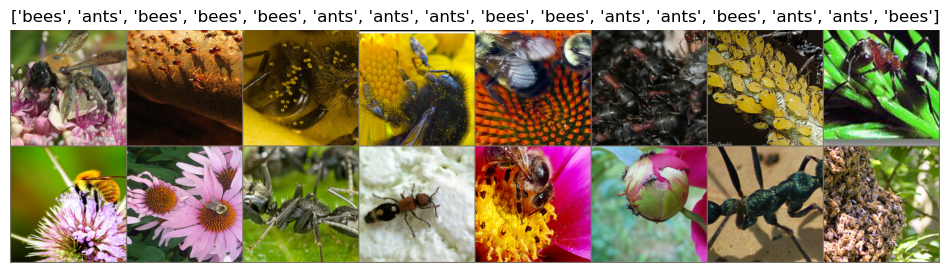

In [908]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.data.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12,4))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[names_classes[x] for x in classes])

In [913]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.classifier.in_features

model.fc = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0);

In [919]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)


In [922]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc
    
#-----------------------------
def train(model, dataloader, optimizer, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#--------------------------
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#-------------------
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [925]:
def fit(model, train_loader, val_loader, optimizer, 
        criterion, metric, epochs = 10, 
        device='cpu',  path_best = 'best_model.pt', verbose = True):
    
    best_valid_loss = float('inf')
    
    # Инициализация истории обучения
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'epoch_time': []
    }

    for epoch in trange(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)
        
        # Сохранение метрик в историю
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path_best)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        history['epoch_time'].append(epoch_mins * 60 + epoch_secs)  # сохраняем время в секундах

        if verbose == True:
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
            f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%') 
    
    return history

In [930]:
metric    = accuracy

In [933]:
EPOCHS = 10
history = fit(model, trainloader, valloader, optimizer, criterion, metric, epochs = EPOCHS, device=device, verbose = True)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.845 | Train Acc: 42.19%  | Val. Loss: 1.372 | Val. Acc: 77.78%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.059 | Train Acc: 78.91%  | Val. Loss: 0.835 | Val. Acc: 90.76%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.741 | Train Acc: 81.25%  | Val. Loss: 0.659 | Val. Acc: 89.51%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.645 | Train Acc: 80.47%  | Val. Loss: 0.572 | Val. Acc: 87.01%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.550 | Train Acc: 87.11%  | Val. Loss: 0.545 | Val. Acc: 89.51%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.531 | Train Acc: 83.98%  | Val. Loss: 0.507 | Val. Acc: 89.51%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.493 | Train Acc: 85.94%  | Val. Loss: 0.468 | Val. Acc: 90.76%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.460 | Train Acc: 88.28%  | Val. Loss: 0.445 | Val. Acc: 91.39%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.434 | Train Acc: 89.06%  | Val. Loss: 0.431 | Val. Acc: 90.14%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 2s
	Train Loss: 0.423 | Train Acc: 89.06%  | Val. Loss: 0.422 | Val. Acc: 88.89%


In [936]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\n Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

-------------------- 
 Test Loss: 0.422 | Test Acc: 88.89%


# Обучение модели

## Загрузка набора данных

Датасет `train_test_tricks_256` представляет собой структурированную директорию с изображениями, организованными по директориям - категориям (классам). Формат соответствует стандартному шаблону для задач классификации изображений `ImageFolderDataset`: отдельные папки‑классы, внутри которых — файлы изображений.

Структура каталогов
Корневая папка датасета содержит 8 подпапок (по числу классов):
```bash

train_test_tricks_256/
├── apple_pie/
├── chicken_wings/
├── cup_cakes/
├── eggs_benedict/
├── falafel/
├── Planes/
├── Ships/
└── Trains/

```
В каждой подпапке находятся изображения, соответствующие названию класса (например, в `apple_pie/` — фото яблочных пирогов).

In [792]:
dataset_pth = os.path.join('data','train_test_tricks_256')
os.listdir(dataset_pth)

['apple_pie',
 'chicken_wings',
 'cup_cakes',
 'eggs_benedict',
 'falafel',
 'Planes',
 'Ships',
 'Trains']

Для формата `ImageFolderDataset` есть готовые шаблоны датасетов `torch`

In [795]:
dataset = torchvision.datasets.ImageFolder(dataset_pth, transform=transform_val)

In [796]:
dataset

Dataset ImageFolder
    Number of datapoints: 7397
    Root location: data\train_test_tricks_256
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               MaybeToTensor()
               Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
           )

In [797]:
names_classes = dataset.classes
print('classes:',names_classes)

classes: ['Planes', 'Ships', 'Trains', 'apple_pie', 'chicken_wings', 'cup_cakes', 'eggs_benedict', 'falafel']


Проведем разделение датасета 

* обучающую (train_dataset);

* валидационную (val_dataset);

* тестовую (test_dataset).

Двухэтапное разделение позволяет сначала выделить независимую тестовую выборку, а затем — валидационную из оставшейся части.

Случайное разделение (random_split) обеспечивает репрезентативность каждой выборки.

> random_split() — встроенная функция PyTorch для случайного разделения датасета по заданным размерам.

In [842]:
train_transform =  transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

In [844]:
# Определение размеров выборок
dataset_size = len(dataset)
train_size = int(0.5 * dataset_size)  
val_size   = int(0.3 * dataset_size)  
test_size  = dataset_size - train_size - val_size 

train_dataset_, test_dataset = random_split(dataset, [train_size+val_size, test_size])
train_dataset, val_dataset  = random_split(train_dataset_, [train_size, val_size])



Присвоим заданные преорбазования для каждой из частей.

In [846]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = test_transform
test_dataset.dataset.transform  = test_transform

Создадим загрузчик данных для кажой части

In [870]:
BATCH_SIZE = 128

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_size,      batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

In [872]:
print(type(train_dataset))  # должно быть <class '...Dataset'>
print(type(val_dataset))

print(type(train_loader.dataset))  # должно быть Dataset, а не int

<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


Проверим визуализацию батчей.

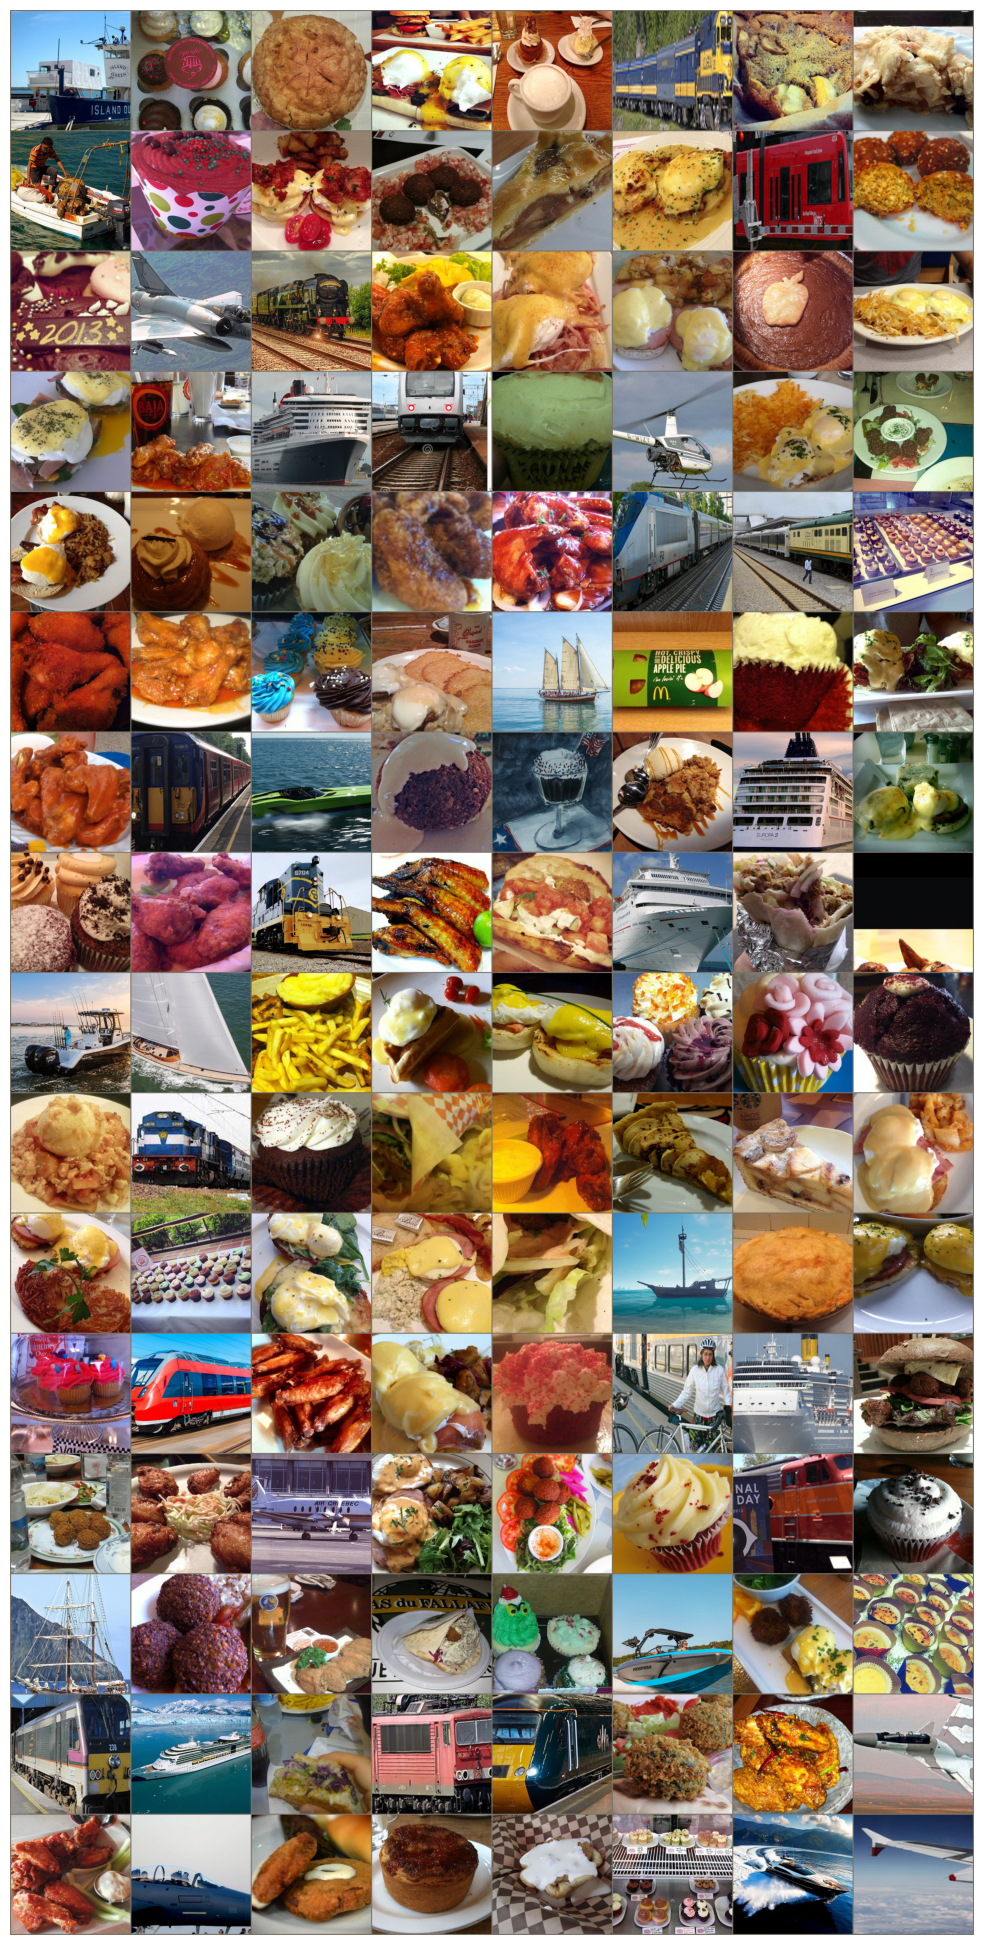

In [852]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(35,25))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, )

## Функции для обучения

In [855]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc
    
#-----------------------------
def train(model, dataloader, optimizer, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#--------------------------
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#-------------------
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


Дополним функцию `fit` расписанием обучения

In [858]:
def fit(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    metric,
    epochs=10,
    scheduler=None,
    patience=None,  
    device='cpu',
    path_best='best_model.pt',
    verbose=True,
    metric_name='acc'  # гибкое имя метрики
):
    """
    Обучает модель с поддержкой early stopping и сохранением лучшей модели.
    
    Args:
        patience (int): количество эпох без улучшения до остановки.
        metric_name (str): имя метрики для отслеживания (например, 'acc', 'f1').
    """
    if patience is None:
        patience = epochs

    best_valid_metric = -float('inf')  # максимизируем метрику
    patience_counter = 0
    best_epoch = 0

    history = {
        'train_loss': [],
        f'train_{metric_name}': [],
        'valid_loss': [],
        f'valid_{metric_name}': [],
        'epoch_time': []
    }

    for epoch in trange(epochs, desc="Training"):
        start_time = time.monotonic()

        model.train()
        train_loss, train_metric = train(model, train_loader, optimizer, criterion, metric, device)
        
        model.eval()
        valid_loss, valid_metric = evaluate(model, val_loader, criterion, metric, device)

        # Scheduler step
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(valid_loss)  # или valid_metric, если максимизируем
            else:
                scheduler.step()

        # Логгирование
        history['train_loss'].append(train_loss)
        history[f'train_{metric_name}'].append(train_metric)
        history['valid_loss'].append(valid_loss)
        history[f'valid_{metric_name}'].append(valid_metric)

        # Early stopping & checkpointing
        if valid_metric > best_valid_metric:
            best_valid_metric = valid_metric
            best_epoch = epoch
            torch.save(model.state_dict(), path_best)
            patience_counter = 0
        else:
            patience_counter += 1

        # Время эпохи
        end_time = time.monotonic()
        epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)
        history['epoch_time'].append(epoch_mins * 60 + epoch_secs)

        # Вывод
        if verbose:
            lr = optimizer.param_groups[0]['lr']
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | LR: {lr:.4f}')
            print(f'\tTrain Loss: {train_loss:.3f} | Train {metric_name.title()}: {train_metric*100:.2f}% | '
                  f'Val Loss: {valid_loss:.3f} | Val {metric_name.title()}: {valid_metric*100:.2f}%')

        # Early stopping
        if patience_counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch+1}. Best epoch: {best_epoch+1}")
            break

    history = pd.DataFrame(history)
    history.attrs.update({
        'best_epoch': best_epoch,
        'best_valid_metric': best_valid_metric,
        'metric_name': metric_name,
        'total_epochs': len(history)
    })
    return history

### Обучение модели

In [861]:
model = timm.create_model('mobilenetv3_small_050', 
                          pretrained=True, 
                          num_classes=len(names_classes), 
                          in_chans=3)

for param in model.parameters():
    param.requires_grad = False
model.get_classifier().requires_grad_(True)

def init_classifier(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Применяем ТОЛЬКО к голове
model.classifier.apply(init_classifier)

Linear(in_features=1024, out_features=8, bias=True)

In [863]:
optimizer = create_optimizer_v2(
    model,
    opt='adamw',
    lr=LR_START,
    weight_decay=0.05
)

scheduler, _ = create_scheduler_v2(
    optimizer,
    sched='cosine',
    num_epochs=num_epochs,
    min_lr=1e-6,
    warmup_lr=1e-6,
    warmup_epochs=3
)


In [867]:
EPOCHS = 30
history = fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = EPOCHS, device=device, verbose = True)

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating: 0it [00:00, ?it/s]

TypeError: object of type 'int' has no len()

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

## Задания

__1.__ Перед обучением модели на большом наборе данных [иногда рекомендуется](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks#good-practices) выбрать минибатч, для которого проверяется что модель действительно работает и не дает сбоев.  __Предлагается__ проверить точность модели на подвыборке набора данных (например на одном батче). 
> Отметим, что нормальным размером батча считается 32 - 128 семплов.

__2.__ В том числе, на небольшом батче модель проверяется на предмет переобучения. Модель "нормальной" сложности должна переобучиться, если выбрать достаточно много эпох, не слишьком маленькую скорость обучения и другие гиперпараметры. __Предлагается__ переобучить модель на небольшом батче.

__3.__ Если модель переобучена, то ее следует вывести зи переобучения путем регуляризаций (увеличение набора данных, аугментация, нормализация / дропаут, и тд). __Предлагается__ проверить, как модель выйдет из состояния переобучения.

# Приемы обучения НС

## Инициализация обучения

Для повышения качества работы с моделями проведем инициализацию весовых параметров при помощи модуля [`nn.init`](https://pytorch.org/docs/stable/nn.init.html).

> Отметим, что в ряде случаев достаточно инициализации «по умолчанию». В других случаях лучше проводить рекомендованные схемы инициализации. Однако, пробуя вручную различные схемы инициализации, мы обычно можем добиться небольшого улучшения производительности.

Инициализируем параметры, создавая функцию, которая принимает модуль (слой) модели, проверяет, какого типа этот слой, а затем использует методы `nn.init` для инициализации параметров рекомендуемым способом.

В достаточно общем случае можно сказать, что инициализация имеет вид нормального или равномерного распределений с параметром (стандартным отклонением или разбросом), заданным:

$$\frac{\text{gain}}{\sqrt{\text{fan mode}}}$$

Значение $\text{gain}$ зависит от нелинейности, которая будет использована после слоя. Например, `ReLU` устанавливает $\text{gain}$ в $\sqrt{2}$. Значение $\text{fan mode}$ может быть либо `fan_in`, либо `fan_out`. `fan_in` — это количество соединений, входящих в слой, а `fan_out` — количество соединений, выходящих из слоя. Количество соединений — это количество параметров (оно есть не только у полносвязного слоя, но и у остальных слоев). Для линейного слоя можно записать названную инициализацию как $$\frac{\text{2}}{\sqrt{\text{fan in}+\text{fan out}}}$$     
> Например, для сверточного слоя на вход поступает фильтр 3x3x3, поэтому `fan_in` равно 27, а на выход — 64x3x3, поэтому `fan_out` равно 576. Эта схема инициализации называется *Kaiming Normal*, также известная как *Xe Normal*.

В `nn.init` есть функция `calculate_gain`, которая рассчитывает $\text{gain}$ для заданных функций активации.

При инициализации — инициализируем члены смещения нулями.

> Зачем вообще нужно инициализировать параметры? Мы хотим, чтобы выходы каждой функции активации (и, следовательно, входы последующего слоя) имели среднее значение 0 и стандартное отклонение 1. Тогда выход производной функций активации будет максимальным, а значения весов не приведет к вымыванию или взрыву градиента.

Подробней о рекомендациях инициализации смотрите [в документации](https://pytorch.org/docs/stable/nn.init.html).

In [ ]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

Применим инициализацию с помощью метода модели `apply`. Это вызовет заданную функцию на каждом модуле и подмодуле в модели.  

In [ ]:
model.apply(initialize_parameters)

> Смотрите также примеры визуализации весовых параметров [при различных стратегиях инициализации](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html?highlight=initialization) и [тут](https://www.deeplearning.ai/ai-notes/initialization/index.html).

## Поиск диапазона скоростей обучения

Проведем поиск оптимальной скорости обучения. 
Для этого используем готовую утилиту [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder). 
<!-- Код здесь взят из урезанной и слегка модифицированной версии  [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder).
```python
from torch.optim.lr_scheduler import _LRScheduler

class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

    best_lr = lrs[np.argmin(losses)]

    print(f'Best lr = {best_lr:.5f}')

    return best_lr

best_lr = plot_lr_finder(lrs, losses)
``` -->

**Примечание**: поиск скорости обучения — это скорее искусство, чем наука. Алгоритм не сможет найти точную скорость обучения с точностью до $5$ знаков после запятой, которая всегда будет давать нам $100\%$ точность — но обычно это будет лучше, чем просто выбрать скорость обучения из воздуха.  

Наиболее часто используемый оптимизатор — `Adam`. Скорость обучения `Adam` по умолчанию обычно является отличным выбором, но, подобно тому, как вручную инициализировали параметры, чтобы потенциально получить некоторое улучшение производительности, мы можем попытаться рассчитать оптимальную скорость обучения вручную.  

Как работает система поиска скорости обучения? В алгоритм `finder` подается модель, оптимизатор и критерий, который хотелось бы использовать. Оптимизатору задается скорость обучения с гораздо меньше, чем предполагается использовать. Затем обучаются модели на данных из обучающего набора — вычисляются потери и обновляются параметры. После каждой партии экспоненциально увеличивается скорость обучения. Так делается вплоть до заданного верхнего предела. Это повторяется до тех пор, пока значения функции потерь не начинают расходится более чем в 5 раз по сравнению с наилучшими потерями или пока не достигнута максимальная скорость обучения.  

Вычисленные функции потерь обычно довольно шумные, поэтому сохраняется экспоненциальное среднее значений по батчам.  

При настоящем обучении необходимо использовать инициализированные параметры, а не те, которые были обновлены в результате поиска скорости обучения. Поэтому сохраним параметры модели на диск при инициализации алгоритма поиска, а затем сбросим их на желаемые инициализированные параметры непосредственно перед возвратом функции `range_test`, загружая начальные значения с диска.

Сначала создается экземпляр класса `finder` с моделью, оптимизатором и функцией потерь. Затем мы используем `range_test` с обучающим итератором, максимальной скоростью обучения и количеством итераций, которые мы хотим использовать. 

In [ ]:
!pip3 install torch_lr_finder
from torch_lr_finder import LRFinder

In [ ]:
START_LR = 1e-7
model = Model(3,10)
model.apply(initialize_parameters)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


optimizer = optim.Adam(model.parameters(), lr=START_LR)

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader, end_lr=1, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


Проверим точность для найденной скорости обучения. Отметим, что найденная скорость - это скорее правильный порядок скорости обучения, нежели чем точное значение. В данном случае порядок можно оценить как $0.001 - 0.1$.

In [ ]:
model = Model()
model.apply(initialize_parameters)
model = model.to(device)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
        f'| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

## Оптимизация параметров обучения по блокам

При обучении моделей часто оказывается желательным проведение [настройки параметров обучения](https://pytorch.org/docs/stable/optim.html#module-torch.optim).
Например, в ряде случаев полезным оказывается использование отдельных параметров обучения для экстрактора признаков и его головной части. Этот прием будет еще упомянут в разделе перенос признаков. Тут, однако, тоже его отметим. Прием использования различных скоростей обучения позволяет регулировать интенсивность обучения. Например, если мы ожидаем, что часть нейронной сети предобучена, то для нее скорость обучения должна быть гораздо ниже (если предобученные слои вообще нуждаются в обучении). 

> Часто при использовании предобученных сетей используется гипотеза заключается в том, что ранние слои нейронной сети учатся извлекать более общие признаки, в то время как поздние слои учатся извлекать более специфичные для конкретной задачи признаки. Если это так, то общие признаки, извлекаемые ранними слоями, должны быть полезны для любой задачи, и мы должны изменять их предварительно обученные веса на очень небольшую величину — если вообще должны.

> Дискриминативную тонкую настройку параметров обучения обычно нет необходимости использовать при обучении модели на основе случайно инициализированных весов.


In [ ]:
model = Model()
model.apply(initialize_parameters)
model = model.to(device)
criterion = criterion.to(device)

LR = 1e-2;

params = [
          {'params': model.feature_extractor.parameters(), 'lr': LR / 2},
          {'params': model.fc.parameters(), 'lr': LR }
         ]

optimizer = optim.Adam(params, lr=LR)

> Отметим, что могут быть вырабнны и другие функции потерь, например см. [тут](https://kevinmusgrave.github.io/pytorch-metric-learning/).

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

## Планировщик скорости обучения

Другим полезным приемом будет использовать [планировщик скорости обучения](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) `learning rate scheduler`. Планировщик скорости обучения динамически изменяет скорость обучения во время обучения модели. 
 
В наиболее простом случае планировщик скорости обучения задается из пакета `torch.optim.lr_scheduler` как одноцикловой планировщик. То есть он имеет только один цикл изменения скорости. 

Ниже показан пример визуализации для 4 типов планировщиков. 

> Обратите внимание, что текущее значение скорости обучения можно получить как `optimizer.param_groups[0]["lr"]`. Аналогичным образом мы его возвращаем после каждого цикла оптимизатора. 



Отметим, следующие [практики использования изменяющейся скорости обучения](https://github.com/Devinterview-io/pytorch-interview-questions?tab=readme-ov-file#process-for-implementing-custom-layers):
* __Начните с фиксированной скорости__. Начните обучение с постоянной скорости обучения, чтобы установить базовый уровень и обеспечить начальную сходимость.
* __Настройте параметры планировщика__. Размер шага (`step_size`), гамма (`gamma`) и другие параметры планировщика сильно влияют на производительность модели. Поэкспериментируйте с различными настройками, чтобы найти оптимальный вариант для ваших данных и модели.
* __Следите за потерями и метриками__. Следите за метриками обучения и проверки. Планировщики скорости обучения могут помочь точно настроить модель, адаптируясь к ее изменяющимся потребностям во время обучения.

Когда следует использовать планирование скорости обучения:
* __Разреженные данные__. Для данных с разреженными признаками планирование может помочь модели сосредоточиться на менее распространенных признаках, тем самым повышая производительность.
* __Медленно и быстро обучающиеся признаки__. Не все признаки должны обновляться с одинаковой скоростью. Например, в нейронных сетях весам более ранних слоев может потребоваться больше времени для сходимости. Планирование может помочь ускорить их обновление.
* __Плато потерь__. Когда функция потерь сглаживается, указывая на то, что модель мало чему учится при текущей скорости обучения, планировщик может снизить скорость и вывести модель из колеи.

In [ ]:
LR_START = 0.02
optimizer = optim.SGD(model.parameters(), lr=LR_START, momentum=0.9)

In [ ]:
epochs = 20


schedulers = {'step_lr':torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5),
              'exp_lr':torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.1),              
              'cos_lr':torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0),
              'warm_up_lr':torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                   T_0=19, T_mult=1, 
                                                                   eta_min=0.001)}

lrs = np.zeros((len(schedulers), epochs))
fig, axs = plt.subplots(2,2,figsize=(6,4));

with torch.inference_mode():
     
    for j, (k,scheduler) in enumerate(zip(schedulers.keys(), schedulers.values())):

        for i in range(epochs):
            optimizer.step()
            lrs[j,i] = optimizer.param_groups[0]["lr"]
            scheduler.step()
        optimizer.param_groups[0]["lr"]  = 0.01
        axs.ravel()[j].plot(range(epochs),lrs[j]); 
        axs.ravel()[j].set_title(k);


<blockquote>
    
Отметим, что также может быть использован планировщик `ReduceLROnPlateau`, который снижает скорость обучения автоматически при выходе валидации на плато.
    
```python

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(10):
        train(...)
        val_loss = validate(...)
        # Note that step should be called after validate()
        scheduler.step(val_loss)
```

Дополним функцию тренировки новым аргументом `scheduler`.

In [ ]:
def train(model, dataloader, optimizer, criterion, metric, scheduler=None,  device = 'cpu'):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type= 2)
        
        optimizer.step()                

        epoch_loss += loss.item()
        epoch_acc  += acc.item()
    

        
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Проверим работу расписания. 

Следует также отметить, что помимо расписания ниже приведен следующий код:
```python
    max_grad = 10
    for p in model.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -0.1, max_grad))
```

Такой прием позволяет ограничить значение градиента (`gradient clipping`): `lambda grad: torch.clamp(grad, -0.1, max_grad)`. Прием применяется для всех параметров, так как задан цикл. При этом данный прием записывается как дополнительная функция при расчете градиента. Это реализовано через т.н. `hook`. По средствам метода `register_hook` подобно `callback` каждому параметру ставится дополнительная функция в соответствие.

Отметим, что можно бы было провести `gradient clipping` при помощи встроенной утилиты `torch.nn.utils.clip_grad_norm_`. В функции `train` выше эта строка закомментирована. 

In [ ]:
LR_PERIOD = 2
LR_DECAY  = 0.9
LR = 0.012;


model = Model()
model = model.to(device)
criterion = criterion.to(device)

model.apply(initialize_parameters)

max_grad = 10
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -0.1, max_grad))

optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size = LR_PERIOD, 
                                            gamma     = LR_DECAY)


In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, scheduler)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)
    
    if scheduler != None:
        scheduler.step()
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR {optimizer.param_groups[0]["lr"] :.4f}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
        f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

<!-- https://pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py
from torchvision.transforms import v2
NUM_CLASSES = 10
alpha  = 0.5

cutmix = v2.CutMix(num_classes=NUM_CLASSES, alpha = alpha)
mixup = v2.MixUp(num_classes=NUM_CLASSES, alpha = alpha)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

for images, labels in train_loader:
    images = images.reshape(-1,1,28,28)
    print(f"Before CutMix/MixUp: {images.shape = }, {labels.shape = }")
    images, labels = cutmix_or_mixup(images, labels)
    print(f"After  CutMix/MixUp: {images.shape = }, {labels.shape = }")
    
    targets1, targets2 = 
    loss = alpha * criterion(preds, targets1) + (1 - self.alpha) * criterion(preds, targets2)

    break
    
targets = torch.nonzero(labels).reshape(-1,4)[:,1::2]
    
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape  

class CutMixCELoss(nn.Module):
    def __init__(self, alpha = 0.5):
        super(CutMixCELoss, self).__init__() 
        self.criterion = nn.CrossEntropyLoss
        self.alpha = alpha

    def farward(self, preds, targets):
        targets1, targets2  = targets
        return self.alpha * self.criterion(preds, targets1)\
            + (1 - self.alpha) * self.criterion(preds, targets2)
            
```python
    from torch.utils.data import default_collate

    def collate_fn(batch):
        return cutmix_or_mixup(*default_collate(batch))
    
    
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn) -->

## Задания

**1.** Проверьте, как влияют те или иные режимы инициализации на качество работы нейронной сети. Например, инициализация постоянными величинами `nn.init.constant_(m.weight, constant_weight)`.

__2.__  В ряде [случаев](https://discuss.pytorch.org/t/tricks-for-being-able-to-use-a-higher-learning-rate/142179) рекомендуется стратегия обучения, когда изначально используется крайне низкая скорость обучения в течение нескольких эпох, чтобы веса модели настроились в нужном направлении. Такие эпохи будут сравнительно бесполезными с точки зрения результата обучения, но повышают стабильность экспериментов. Затем скорость обучения резко увеличивают и начинают плавно снижать. Предполагается, что после первоначальной настройки весов они могут быстро обучиться в нужном направлении. __Предлагается__ реализовать эту стратегию самостоятельно.

> Также иногда используют циклическую скорость обучения для большого числа эпох.

<code style="color : red">__3.*__</code> В ряде [работ](https://openreview.net/pdf?id=B1Yy1BxCZ) рекомендуется вместе с изменением скорости обучения (с ее снижением) [увеличивать размер батча](https://stackoverflow.com/questions/53033556/how-should-the-learning-rate-change-as-the-batch-size-change). __Предлагается__ реализовать эту стратегию обучения самостоятельно. 

> [Иногда](https://ar5iv.labs.arxiv.org/abs/1803.09820) также рекомендуют уменьшать затухание весов с ростом эпохи обучения (параметр `L2` регуляризации — `weight_decay` в оптимизаторах). Если используется параметр `momentum`, то он должен снижаться с увеличением скорости обучения [или циркулировать](https://ar5iv.labs.arxiv.org/abs/1803.09820).

<code style="color : red">__4.*__</code> Настройка параметров обучения может быть выполнена не только по блокам модели, но и по отдельным параметрам. Например, если используется `SGD with weight_decay`, иногда полезно отключить `weight_decay` для параметра смещения. Это можно сделать следующим образом.
    
```python
    bias_params = [p for name, p in self.named_parameters() if 'bias' in name]
    others = [p for name, p in self.named_parameters() if 'bias' not in name]

    optim.SGD([
                    {'params': others},
                    {'params': bias_params, 'weight_decay': 0}
                ], weight_decay=1e-2, lr=1e-2)
```
> Отметим, что также [в ряде случаев](https://github.com/NVIDIA/DeepLearningExamples/blob/8d8b21a933fff3defb692e0527fca15532da5dc6/PyTorch/Classification/ConvNets/image_classification/training.py)  'weight_decay' не используется для параметров батч-нормализации.

__Предлагается__ проверить качество такого оптимизатора самостоятельно.

<code style="color : red">__5.*__</code> Иногда в функцию потерь также добавляют параметр [`label_smoothing`](https://paperswithcode.com/method/label-smoothing), выставляя его небольшим. При этом итоговая метка класса формируется как $$ y_s = (1-\eta y) + U[0, \eta/K] $$ где $\eta$ — весовой коэффициент, $K$ — число классов, а $U[0, \eta/K]$ — равномерное распределение. То есть $y_s$ представляет собой вектор, где основной класс имеет значение в диапазоне $(0,1)$, а остаток этого диапазона «размыт» между значениями остальных классов. В таком случае ожидается, что подразумеваемая функция активации $softmax$ не будет выходить в насыщение, что снизит вероятность переобучения слоя принятия решений. Сегодня `label_smoothing` в оригинальной функции потерь, как это показано ниже. __Предлагается__ попробовать использовать эту функцию самостоятельно.

```python 
    nn.CrossEntropyLoss(label_smoothing = ...)
```